<img src="dbpedia_getting_started.jpg">

# Experimental area for interacting with Parthenos Discovery platform

Data notebooks are increasingly popular, as they offer "in browser code execution" and easy sharing and reproducing of algorithmis procedures.
In the context of Parthenos Discovery, the Juypter notebooks provide more freedom as to postprocessing of the resulting data. For querying the data we use [SPARQL](https://www.w3.org/TR/sparql11-query/). https://parthenos.acdh-dev.oeaw.ac.at/


Credits:
Based on [notebooks from gastrodon](https://github.com/paulhoule/gastrodon/blob/master/notebooks/remote/Querying%20DBpedia.ipynb)
"My method is a deliberate combination of systematic analysis (looking at counts, methods that can applied to arbitrary predicates or classes) and opportunism (looking at topics that catch my eye.)"


In [1]:
import sys
from os.path import expanduser
from gastrodon import RemoteEndpoint,QName,ttl,URIRef,inline
import pandas as pd
import json
pd.options.display.width=120
pd.options.display.max_colwidth=100

First let's define a few prefixes for namespaces we will use:

In [2]:
prefixes=inline("""
    @prefix : <http://dbpedia.org/resource/> .
    @prefix pe: <http://parthenos.d4science.org/CRMext/CRMpe.rdfs/> .
    @prefix crm: <http://www.cidoc-crm.org/cidoc-crm/> .
    @prefix crmdig: <http://www.ics.forth.gr/isl/CRMext/CRMdig.rdfs/> .
""").graph

Next we set up a SPARQL endpoint and register the above prefixes. 
Setting the base_uri helps to make the results more readable, by stripping the URI in the base_uri namespace.
We leave the default_graph empty, because the data is grouped in many graphs (based on their provenance).

In [3]:
# for connecting to an endpoint with restricted access, you need to provide the credentials:
#connection_data=json.load(open(expanduser("config.json")))
#connection_data["prefixes"]=prefixes
#endpoint=RemoteEndpoint(**connection_data)

In [6]:
# for ease of use a dedicated PARTHENOS endpoint is available that allows anonymous read-access (SELECT queries)
endpoint=RemoteEndpoint(
    "https://triplestore-parthenos-cached.acdh-dev.oeaw.ac.at/parthenos-dev/sparql"
    ,default_graph=""
    ,prefixes=prefixes
    ,base_uri="http://parthenos.d4science.org/handle/"
)

## Counting Triples

First let's count how many triples there are in the triple store, to get a first idea of the size of the overall dataset.

In [10]:
count=endpoint.select("""
    SELECT (COUNT(*) AS ?count) { ?s ?p ?o .}
""").at[0,"count"]
format(count, ",")

'185,192,420'

## Counting Predicates

A list of predicates and their frequency.

In [11]:
predicates=endpoint.select("""
    SELECT ?p (COUNT(*) AS ?count) { ?s ?p ?o .} GROUP BY ?p ORDER BY DESC(?count)
""")
predicates

,count
p,
rdf:type,58451775
rdfs:label,44609310
crm:P2_has_type,17738324
crm:P129_is_about,5165744
pe:PP8i_is_dataset_hosted_by,4584102
crm:P1_is_identified_by,3763327
pe:PP49_provides_access_point,3617496
crm:P3_has_note,3539679
crm:P4_has_time-span,3193804


Just give me the number of distinct predicates used:

In [12]:
endpoint.select("""
    SELECT (COUNT(*) AS ?count) { SELECT DISTINCT ?p { ?s ?p ?o .} }
""")

,count
0,120


When you have a number of "things" ordered by how prevalent they are, a cumulative distribution function is a great nonparametric method of characterizing the statistics

In [14]:
predicates["dist"]=predicates["count"].cumsum()/count

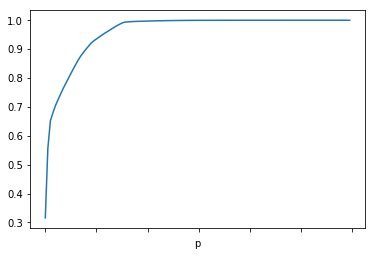

In [15]:
%matplotlib inline
predicates["dist"].plot()

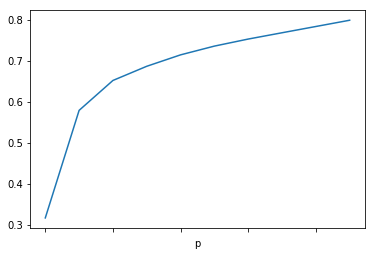

In [29]:
predicates["dist"].head(10).plot()

Top 10 predicates represent around 80% of the predicates in the dataset. Which are they?

In [18]:
predicates.head(10)

,count,dist
p,,
rdf:type,58451775,0.315627
rdfs:label,44609310,0.556508
crm:P2_has_type,17738324,0.652291
crm:P129_is_about,5165744,0.680185
pe:PP8i_is_dataset_hosted_by,4584102,0.704938
crm:P1_is_identified_by,3763327,0.725260
pe:PP49_provides_access_point,3617496,0.744793
crm:P3_has_note,3539679,0.763907
crm:P4_has_time-span,3193804,0.781153


And which are the least used properties then? 
Let's see those used less than 20 times:

In [26]:
rare_predicates = predicates[predicates['count']<20]
rare_predicates

,count,dist
p,,
pe:PP47_has_protocol_type,17,0.999999
pe:PP42_has_declarative_time,15,1.000000
http://www.w3.org/2004/02/skos/core#scopeNote,12,1.000000
crm:P16_used_specific_object,12,1.000000
crm:PP2_provided_by,8,1.000000
http://www.w3.org/2002/07/owl#inverseOf,8,1.000000
pe:PP11i_is_volatile_digital_object_curated_by,7,1.000000
crm:P103i_was_intention_of,6,1.000000
crm:P74_has_current_or_former_residence,4,1.000000


# Classes

Let's also get some numbers on the classes. How many instances of each class are there:

In [28]:
types=endpoint.select("""
    SELECT ?type (COUNT(*) AS ?count) { ?s a ?type .} GROUP BY ?type ORDER BY DESC(?count)
""")
types

,count
type,
crm:E55_Type,14725979
crmdig:D7_Digital_Machine_Event,3961159
pe:PE15_Data_E-Service,3722902
pe:PE29_Access_Point,3519019
crm:E39_Actor,3272917
crm:PC14_carried_out_by,3166841
pe:PE22_Persistent_Dataset,3104700
crm:E52_Time-Span,3058084
crm:E30_Right,2648917


In [29]:
endpoint.select("""
    SELECT (COUNT(*) AS ?count) { SELECT DISTINCT ?type { ?s a ?type .} }
""")

,count
0,80


Show me jsut the CIDOC CRM classes:

In [33]:
types[types.index.str.startswith('crm:')]

,count
type,
crm:E55_Type,3708891
crm:E42_Identifier,792528
crm:E52_Time-Span,767167
crm:E39_Actor,760907
crm:PC14_carried_out_by,710083
crm:E35_Title,647214
crm:E33_Linguistic_Object,406172
crm:E73_Information_Object,371244
crm:E65_Creation,342374


Let's have a look at instances of one class, say **crm:E38_Image**:

In [54]:
images = endpoint.select("""
    SELECT ?img { 
        ?img a crm:E38_Image
    } LIMIT 10
""")
images

,img
0,http://194.242.241.163/fedora/objects/coll:623/datastreams/MM201297/content
1,http://194.242.241.163/fedora/objects/coll:617/datastreams/MM201213/content
2,http://194.242.241.163/fedora/objects/coll:523/datastreams/MM185965/content
3,http://194.242.241.163/fedora/objects/coll:269/datastreams/MM92110/content
4,http://194.242.241.163/fedora/objects/coll:321/datastreams/MM195463/content
5,http://194.242.241.163/fedora/objects/coll:585/datastreams/MM199851/content
6,http://194.242.241.163/fedora/objects/coll:320/datastreams/MM195462/content
7,http://194.242.241.163/fedora/objects/coll:614/datastreams/MM201064/content
8,http://194.242.241.163/fedora/objects/coll:322/datastreams/MM195465/content
9,http://194.242.241.163/fedora/objects/coll:636/datastreams/MM210883/content


In [51]:
#from bs4 import BeautifulSoup
from IPython.display import display, HTML
#from uritools import urijoin

HTML('<img src="{0}">'.format(images.at[3,'img']))

Or list me all ten as thumbnail:

In [70]:
htmlimgs = ""
for ix,row  in images.iterrows():    
   htmlimgs = htmlimgs + '<img src="{0}" style="float:left;height:80px;margin:1em;">'.format(row[0])
HTML(htmlimgs)

Now I want to use a value from one result in the next query. (gastrodon library "lets you use Python variables in your SPARQL queries simply by adding ?_ to the name of your variables")

In [71]:
actors = endpoint.select("""
    SELECT ?actor { 
        ?actor a crm:E39_Actor.
        ?actor rdfs:label ?label.
    } LIMIT 10
""")
actor1 = actors.at[0,'actor']

actor1_properties = endpoint.select("""
    SELECT ?p ?o { 
        ?_actor1 ?p ?o.
    } LIMIT 10
""")
actor1_properties



,p,o
0,rdf:type,crm:E39_Actor
1,rdfs:label,"Kaptein, I.N."
